# Modelado

En esta primera parte del Notebook, vamos a llevar a cabo el modelado y entreno para la predicción de precios de los diamantes.

Se han realizado varias pruebas con varios modelos, features, escalados, encodings, etc. Todos esas pruebas se encuentran en la carpeta 'discarded'.

En este Notebook, vamos a aplicar solamente el modelo y escalados que mejores resultados han dado en las pruebas:

In [41]:
# imports 
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [42]:
#Importamos nuestro dataset limpio de outliers
df= pd.read_csv('../data/train/diamonds_train_cleaned.csv', index_col=[0])

Tal y como hemos comentado en las conclusiones de nuestro EDA, pasamos a la creación de las siguientes features:

In [43]:
df['xy'] = df['x']/df['y']
df['xz'] = df['x']/df['z']
df['zy'] = df['z']/df['y']
df['table_depth'] = df['table']/df['depth']
df['carat/dimensons'] = df ['carat'] / (df['x']* df['y'] * df['z'])

df.replace([np.inf, -np.inf], 0 , inplace=True) #En algún caso donde la dimensión es 0, el valor de la divisón es infinito, por lo que lo pasamos a 0 pra evitar futuros problemas.

#Echamos un vistazo de nuevo al dataset:
df.head()

,depth,table,x,y,z,price,carat,cut,color,clarity,city,xy,xz,zy,table_depth,carat/dimensons
0,62.4,58.0,6.83,6.79,4.25,4268,1.21,Premium,J,VS2,Dubai,1.005891,1.607059,0.625920,0.929487,0.006139
1,61.6,58.0,6.40,6.35,3.93,3513,1.02,Premium,J,VS2,Dubai,1.007874,1.628499,0.618898,0.941558,0.006386
2,62.3,58.0,5.86,5.80,3.63,1792,0.77,Premium,J,VS2,Dubai,1.010345,1.614325,0.625862,0.930979,0.006241
3,59.6,60.0,7.58,7.48,4.49,7553,1.51,Premium,J,VS2,Dubai,1.013369,1.688196,0.600267,1.006711,0.005931
4,60.2,62.0,5.40,5.33,3.23,1176,0.57,Premium,J,VS2,Dubai,1.013133,1.671827,0.606004,1.029900,0.006131


Como concluido en nuestro EDA, pasamos a eliminar algunas de las features más relaciondas entre si:

In [44]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list((df.select_dtypes(include=numerics)).columns)

numerical_columns.remove('price')
numerical_columns.remove('depth')
numerical_columns.remove('x')
numerical_columns.remove('y')
numerical_columns.remove('z')

#Nos quedamos solo con las siguientes características numéricas:
numerical_columns

['table', 'carat', 'xy', 'xz', 'zy', 'table_depth', 'carat/dimensons']

In [45]:
categorical_columns = ['cut', 'color', 'clarity'] #No vamos a tener en cuenta la ciudad

FEATS = numerical_columns + categorical_columns
TARGET = 'price'

In [46]:
df[FEATS].head() #Echamos un vistazo a nuestro dataset solo con las features (el que va a servir de entreno)

,table,carat,xy,xz,zy,table_depth,carat/dimensons,cut,color,clarity
0,58.0,1.21,1.005891,1.607059,0.625920,0.929487,0.006139,Premium,J,VS2
1,58.0,1.02,1.007874,1.628499,0.618898,0.941558,0.006386,Premium,J,VS2
2,58.0,0.77,1.010345,1.614325,0.625862,0.930979,0.006241,Premium,J,VS2
3,60.0,1.51,1.013369,1.688196,0.600267,1.006711,0.005931,Premium,J,VS2
4,62.0,0.57,1.013133,1.671827,0.606004,1.029900,0.006131,Premium,J,VS2


Una vez está el dataset preparado, es hora de categorizar las variables categoricas.

En esta ocasión, vamos a usar el 'Label Encoder':

In [47]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
    
df.head()

,depth,table,x,y,z,price,carat,cut,color,clarity,city,xy,xz,zy,table_depth,carat/dimensons
0,62.4,58.0,6.83,6.79,4.25,4268,1.21,3,6,5,Dubai,1.005891,1.607059,0.625920,0.929487,0.006139
1,61.6,58.0,6.40,6.35,3.93,3513,1.02,3,6,5,Dubai,1.007874,1.628499,0.618898,0.941558,0.006386
2,62.3,58.0,5.86,5.80,3.63,1792,0.77,3,6,5,Dubai,1.010345,1.614325,0.625862,0.930979,0.006241
3,59.6,60.0,7.58,7.48,4.49,7553,1.51,3,6,5,Dubai,1.013369,1.688196,0.600267,1.006711,0.005931
4,60.2,62.0,5.40,5.33,3.23,1176,0.57,3,6,5,Dubai,1.013133,1.671827,0.606004,1.029900,0.006131


Con las variables ya categorizadas, podemos preparar nuestros datasets de entreno y test:

In [48]:
data_train, data_test, target_train, target_test = train_test_split(df[FEATS], df[TARGET], random_state=42)

El algoritmo/librería elegido (y que mejor resultado ha dado en todas las pruebas) es el `eXtreme Gradient Boost` (XGBRegressor).

Tambien aplicacmos un `Standard Scaler `al modelo:

In [49]:
pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

In [50]:
#Entrenamos nuestro modelo:
pipeline_xgb.fit(data_train, target_train);

In [51]:
#Hacemos una primera predicción con los datos de test:
y_pred = pipeline_xgb.predict(data_test)

Pasamos a calcular el RMSE de test, para tener una primera aproximación de como de afinado está nuestro modelo:

In [52]:
rmse = mean_squared_error(target_test, y_pred)**0.5
rmse

522.9817225310803

In [53]:
#Volvemos a entrenar el modelo con el datframe original (sin la separacion de train y test), para tener mas datos en el entreno:
pipeline_xgb.fit(df[FEATS],df[TARGET]); 

Por último, vamos a graficar estos resultados para hacernos una idea de como de bien o mal está la predicción:

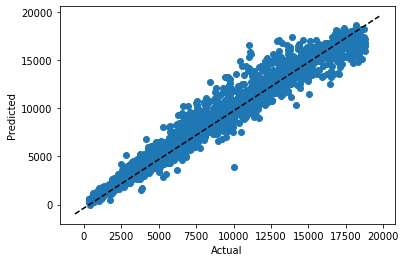

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(target_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
x_lim = plt.xlim()
y_lim = plt.ylim()
plt.plot(x_lim, y_lim, "k--")
plt.show()

# Predicción

En esta segunda parte, vamos a llevar a cabo la predicción de los precios con el modelo entrenado anteriormente.

Para ello, lo hacemos con el dataset con todas las características de los diamantes a predecir.

In [55]:
#Importamos el dataset de test (esta vez ya sin el precio):
diamonds_train=pd.read_csv('../data/test/diamonds_test.csv', index_col=[0])

In [56]:
#Creamos las features como hemos hecho en el dataset de entreno:
diamonds_train['xy'] = diamonds_train['x']/diamonds_train['y']
diamonds_train['xz'] = diamonds_train['x']/diamonds_train['z']
diamonds_train['zy'] = diamonds_train['z']/diamonds_train['y']
diamonds_train['table_depth'] = diamonds_train['table']/diamonds_train['depth']
diamonds_train['carat/dimensons'] = diamonds_train ['carat'] / (diamonds_train['x']* diamonds_train['y'] * diamonds_train['z'])
diamonds_train.replace([np.inf, -np.inf], 0 , inplace=True)

#Comprobamos que todas las features se han creado correctamente:
diamonds_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,city,xy,xz,zy,table_depth,carat/dimensons
id,,,,,,,,,,,,,,,
0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam,0.988115,1.585831,0.623090,0.956938,0.006279
1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat,0.988389,1.629187,0.606676,0.934426,0.006118
2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly,1.008197,1.614880,0.624317,0.980707,0.006359
3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly,0.993475,1.561538,0.636215,0.846395,0.006182
4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam,0.992141,1.583072,0.626719,0.922099,0.006098


In [57]:
#De nuevo aplicamos la categorización (label_encoder ya definido previamente):
for col in categorical_columns:
    diamonds_train[col] = label_encoder.fit_transform(diamonds_train[col])
diamonds_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,city,xy,xz,zy,table_depth,carat/dimensons
id,,,,,,,,,,,,,,,
0,0.79,4,2,2,62.7,60.0,5.82,5.89,3.67,Amsterdam,0.988115,1.585831,0.623090,0.956938,0.006279
1,1.20,2,6,4,61.0,57.0,6.81,6.89,4.18,Surat,0.988389,1.629187,0.606676,0.934426,0.006118
2,1.57,3,4,2,62.2,61.0,7.38,7.32,4.57,Kimberly,1.008197,1.614880,0.624317,0.980707,0.006359
3,0.90,4,2,2,63.8,54.0,6.09,6.13,3.90,Kimberly,0.993475,1.561538,0.636215,0.846395,0.006182
4,0.50,4,2,4,62.9,58.0,5.05,5.09,3.19,Amsterdam,0.992141,1.583072,0.626719,0.922099,0.006098


In [58]:
#Echamos un último vistazo del dataset para la predicción del precio:
diamonds_train[FEATS].head()

,table,carat,xy,xz,zy,table_depth,carat/dimensons,cut,color,clarity
id,,,,,,,,,,
0,60.0,0.79,0.988115,1.585831,0.623090,0.956938,0.006279,4,2,2
1,57.0,1.20,0.988389,1.629187,0.606676,0.934426,0.006118,2,6,4
2,61.0,1.57,1.008197,1.614880,0.624317,0.980707,0.006359,3,4,2
3,54.0,0.90,0.993475,1.561538,0.636215,0.846395,0.006182,4,2,2
4,58.0,0.50,0.992141,1.583072,0.626719,0.922099,0.006098,4,2,4


In [59]:
#Aplicamos el modelo para predecir los precios:
y_pred = pipeline_xgb.predict(diamonds_train[FEATS])

In [60]:
#Por último, preparamos el daframe para que Kaggle reconozca cada una de las predicciones:
y_pred=pd.DataFrame(y_pred, columns=['price'])
y_pred.reset_index(inplace=True)
y_pred.rename(columns={"index": "id"}, inplace= True)
y_pred

,id,price
0,0,2888.936768
1,1,5825.444336
2,2,8966.384766
3,3,3990.149902
4,4,1616.817017
...,...,...
13480,13480,1641.075073
13481,13481,2438.180420
13482,13482,3122.714111
13483,13483,2093.594482


In [61]:
#Guardamos el dataframe resultante en un CSV para poder cargarlo en Kaggle
y_pred.to_csv('../data/prediction/price_prediction.csv', index= False)